## 시장 지표에 따른 투자
* 주가의 추세나 변동성의 강도를 나타내는 지표로 주로 거래량을 사용함
* EOM, RSI, MFI 등..

In [2]:
import os
import pandas as pd
from tqdm import tqdm

sp_data_dict = dict()
for file_name in os.listdir("data/주가데이터"):
    sp_data = pd.read_csv("data/주가데이터/" + file_name, parse_dates = ['Date'])
    stock_name = file_name.replace('.csv', '')
    sp_data_dict[stock_name] = sp_data

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams

sns.set()
%matplotlib inline
rcParams['font.family'] = 'Malgun Gothic'
rcParams['axes.unicode_minus'] = False

## EOM 지수
* 주가와 거래량의 상관관계를 바탕으로 한 지수
* 거래량이 적은데 주가가 상승하면 EOM 지수가 크고 하락하면 EOM 지수가 작음
* 거래양이 많고 주가 변동이 없으면 0 근처에서 변동
* 즉, EOM 지수나 EOM 이동평균선이 0을 상향 돌파하면 매수 신호, 하향 돌파하면 매도 신호로 볼 수 있음
* EOM = midpoint move / box ratio
* modpoint move = ((당일 고가 + 당일 저가) - (전일 고가 + 전일 저가)) / 2
* box ratio = (거래량 / 10000) / (당일 고가 - 당일 저가)

In [5]:
import numpy as np

# 종목별 eom 지수 계산
eom_data_dict = dict()

for stock_name in tqdm(sp_data_dict.keys()):
    eom_data = sp_data_dict[stock_name].copy()
    high_price = eom_data["High"].values
    low_price = eom_data["Low"].values
    volume = eom_data["Volume"].values

    MM = ((high_price[1:] + low_price[1:]) - (high_price[:-1] + low_price[:-1])) / 2
    BR = (volume[1:] / 10000) / (high_price[1:] - low_price[1:])
    EOM = MM / BR

    eom_data.drop(0, inplace = True)
    eom_data["EOM"] = EOM
    eom_data["EOM_5"] = eom_data["EOM"].rolling(5).mean()
    eom_data["EOM_10"] = eom_data["EOM"].rolling(10).mean()
    eom_data["EOM_20"] = eom_data["EOM"].rolling(20).mean()

    eom_data_dict[stock_name] = eom_data

100%|██████████| 2170/2170 [00:07<00:00, 290.80it/s]


In [8]:
# eom 지수가 이동평균선이 0을 상향 돌파하면 매수, 하향 돌파하면 매도

def ror_using_EOM(eom_data_dict, EOM_col):
    ror_list = []
    for stock_name in tqdm(eom_data_dict.keys()):
        eom_data = eom_data_dict[stock_name]
        EOM = eom_data[EOM_col].values
        buy_point_list = (EOM[1:] > 0) & (EOM[:-1] <= 0)
        buy_point_list = np.insert(buy_point_list, 0, False)
        buy_point_list = eom_data.index[buy_point_list]

        sell_point_list = (EOM[1:] < 0) & (EOM[:-1] >= 0)
        sell_point_list = np.insert(sell_point_list, 0, False)
        sell_point_list = eom_data.index[sell_point_list]
        for bp in buy_point_list:
            if (sum(bp < sell_point_list) > 0) and (bp + 1 <= eom_data.index[-1]):
                buy_price = eom_data.loc[bp + 1, "Close"]
                sp = sell_point_list[sell_point_list > bp][0] + 1
                if sp <= eom_data.index[-1]:
                    sell_price = eom_data.loc[sp, "Close"]
                    ror = (sell_price - buy_price) / buy_price * 100
                    ror_list.append(ror)
            else:
                break
    return np.array(ror_list)

In [9]:
EOM_1_ror = ror_using_EOM(eom_data_dict, "EOM")
EOM_5_ror = ror_using_EOM(eom_data_dict, "EOM_5")
EOM_10_ror = ror_using_EOM(eom_data_dict, "EOM_10")
EOM_20_ror = ror_using_EOM(eom_data_dict, "EOM_20")

100%|██████████| 2170/2170 [01:16<00:00, 28.21it/s]


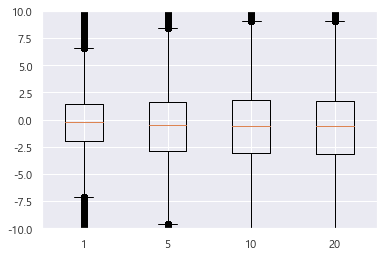

                 0           1           2           3
count  1033917.000  445371.000  311662.000  213402.000
mean         0.176       0.272       0.516       0.673
std          5.645       8.320      10.280      12.296
min        -90.295     -91.836     -71.042     -84.088
25%         -1.962      -2.861      -3.081      -3.180
50%         -0.219      -0.543      -0.574      -0.624
75%          1.448       1.645       1.770       1.731
max        664.131     588.158     857.627    1138.938


In [10]:
# eom 지수 수치를 사용하여 얻은 수익률을 박스플롯으로 시각화

plt.boxplot([EOM_1_ror, EOM_5_ror, EOM_10_ror, EOM_20_ror])
plt.xticks([1, 2, 3, 4], [1, 5, 10, 20])
plt.ylim(-10, 10)
plt.show()

result = pd.concat([pd.Series(EOM_1_ror).describe(),
                    pd.Series(EOM_5_ror).describe(),
                    pd.Series(EOM_10_ror).describe(),
                    pd.Series(EOM_20_ror).describe()], axis = 1)

print(result.round(3))

# 이상치는 대부분 잘렸으나 박스가 -2.5 ~ 2.5 사이에서 형성됨
# 중위수인 주황선이 모두 0 아래에서 형성되었고, 평균도 0 근처로 형성되어 결과는 좋지 않다고 볼 수 있음

## RSI
* 매수와 매도 압력 간의 상대적인 강도를 나타내는 지표
* 0.7 이상이면 초과 매수, 0.3 미만이면 초과 매도 국면
* RSI = n영업일의 상승 폭 합계 / (n영업일의 상승 폭 합계 + n영업일의 하락 폭 합계)

In [11]:
rsi_data_dict = dict()

for stock_name in tqdm(sp_data_dict.keys()):
    rsi_data = sp_data_dict[stock_name][['Close']].copy()
    price = rsi_data["Close"].values
    rise = price[1:] - price[:-1]
    rise[rise < 0] = 0
    fall = price[:-1] - price[1:]
    fall[fall < 0] = 0

    rsi_data.drop(0, inplace = True)
    rsi_data["상승폭"] = rise
    rsi_data["하락폭"] = fall

    for n in [5, 10, 20]:
        sum_rise_n = rsi_data["상승폭"].rolling(n).sum()
        sum_fall_n = rsi_data["하락폭"].rolling(n).sum()
        rsi_data["RSI_" + str(n)] = sum_rise_n / (sum_rise_n + sum_fall_n)

    rsi_data_dict[stock_name] = rsi_data

100%|██████████| 2170/2170 [00:10<00:00, 204.52it/s]


In [12]:
# RSI가 0.3 미만이면 매수, 0.7 이상이면 매도하는 전략

result = pd.DataFrame()

for n in [5, 10, 20]:
    record = []
    for stock_name in tqdm(rsi_data_dict.keys()):
        rsi_data = rsi_data_dict[stock_name]
        RSI = rsi_data["RSI_" + str(n)].values

        buy_point_list = (RSI[1:] < 0.3) & (RSI[:-1] >= 0.3)
        buy_point_list = np.insert(buy_point_list, 0, False)
        buy_point_list = rsi_data.index[buy_point_list]
        sell_point_list = (RSI[1:] >= 0.7) & (RSI[:-1] < 0.7)
        sell_point_list = np.insert(sell_point_list, 0, False)
        sell_point_list = rsi_data.index[sell_point_list]

        for bp in buy_point_list:
            if (sum(bp < sell_point_list) > 0) and (bp + 1 <= rsi_data.index[-1]):
                buy_price = rsi_data.loc[bp + 1, "Close"]
                sp = sell_point_list[sell_point_list > bp][0] + 1
                if sp <= rsi_data.index[-1]:
                    sell_price = rsi_data.loc[sp, "Close"]
                    profit = (sell_price - buy_price) / buy_price * 100
                    record.append(profit)
            else:
                break

    result = pd.concat([result, pd.Series(record).describe()], axis = 1)

result.columns = [5, 10, 20]
print(result)

# 모든 경우에서 평균과 중위수가 양수이며, 기간이 길어질수록 수익률이 높아짐
# 1분위수와 3분위수가 중위값과 멀리 있기 때문에 편차가 크지만 일반적으로 좋은 전략임

100%|██████████| 2170/2170 [00:20<00:00, 106.17it/s]

                  5              10            20
count  408912.000000  227385.000000  98768.000000
mean        0.785783       1.686163      5.531243
std         9.171162      13.361089     21.966329
min       -96.281762     -96.525670    -95.512098
25%        -2.469136      -4.043127     -5.408187
50%         1.219512       2.542373      5.920702
75%         4.681055       7.823129     15.663390
max       622.311176     638.362760    900.113766


In [13]:
# RSI가 0.5 상향 돌파하면 매수, 0.5 하향 돌파하면 매도

result = pd.DataFrame()

for n in [5, 10, 20]:
    record = []
    for stock_name in tqdm(rsi_data_dict.keys()):
        rsi_data = rsi_data_dict[stock_name]
        RSI = rsi_data["RSI_" + str(n)].values

        buy_point_list = (RSI[1:] >= 0.5) & (RSI[:-1] < 0.5)
        buy_point_list = np.insert(buy_point_list, 0, False)
        buy_point_list = rsi_data.index[buy_point_list]
        sell_point_list = (RSI[1:] < 0.5) & (RSI[:-1] >= 0.5)
        sell_point_list = np.insert(sell_point_list, 0, False)
        sell_point_list = rsi_data.index[sell_point_list]

        for bp in buy_point_list:
            if (sum(bp < sell_point_list) > 0) and (bp + 1 <= rsi_data.index[-1]):
                buy_price = rsi_data.loc[bp + 1, "Close"]
                sp = sell_point_list[sell_point_list > bp][0] + 1
                if sp <= rsi_data.index[-1]:
                    sell_price = rsi_data.loc[sp, "Close"]
                    profit = (sell_price - buy_price) / buy_price * 100
                    record.append(profit)
            else:
                break

    result = pd.concat([result, pd.Series(record).describe()], axis = 1)

result.columns = [5, 10, 20]
print(result)

# 평균은 0에 근접하고, 중위수가 모두 음수임. 과반이 실패하는 전략임을 의미

100%|██████████| 2170/2170 [01:39<00:00, 21.77it/s]

                  5              10             20
count  491235.000000  339638.000000  236894.000000
mean        0.271884       0.573149       0.715459
std         8.732927      11.349884      14.099954
min       -93.047619     -90.734824     -90.075529
25%        -2.829568      -3.109656      -3.283582
50%        -0.588235      -0.623053      -0.708299
75%         1.451430       1.486989       1.347638
max       994.017094     975.498575    1241.880342


## MFI
* 자금의 유입과 유출로 가격의 추세전환 시기와 과열 정도를 측정하는 지표. RSI에 거래량을 추가로 고려함
* MFI(Money Flow Index) = MR / (1 + MR)
* MR(Money Ratio) = PMF / NMF
* Positive : 당일 가격이 전일 가격보다 상승 했을때의 MF 합계. N은 하락했을때
* MF(Money Flow) = 거래량 * (당일 고가 + 당일 저가 + 당일 종가) / 3

In [14]:
mfi_data_dict = dict()

# 종목별 MFI 계산
for stock_name in tqdm(sp_data_dict.keys()):
    mfi_data = sp_data_dict[stock_name][['Close']].copy()
    sp_data = sp_data_dict[stock_name]
    close_price = sp_data["Close"].values
    low_price = sp_data["Low"].values
    high_price = sp_data["High"].values
    volume = sp_data["Volume"].values

    MF = volume[1:] * (high_price[1:] + low_price[1:] + close_price[1:]) / 3
    PMF = np.zeros(len(MF))
    NMF = np.zeros(len(MF))

    PMF[close_price[1:] > close_price[:-1]] = MF[close_price[1:] > close_price[:-1]]
    NMF[close_price[1:] < close_price[:-1]] = MF[close_price[1:] < close_price[:-1]]

    mfi_data.drop(0, inplace = True)
    mfi_data["PMF"] = PMF
    mfi_data["NMF"] = NMF

    for n in [5, 10, 20]:
        PMF_n = mfi_data["PMF"].rolling(n).sum()
        NMF_n = mfi_data["NMF"].rolling(n).sum()
        MR = PMF_n / NMF_n
        mfi_data["MFI_" + str(n)] = MR / (1 + MR)

    mfi_data_dict[stock_name] = mfi_data

100%|██████████| 2170/2170 [00:10<00:00, 215.42it/s]


In [16]:
# MFI가 0.3 미만이면 매수, 0.7 이상이면 매도하는 전략

result = pd.DataFrame()
for n in [5, 10, 20]:
    record = []
    for stock_name in tqdm(mfi_data_dict.keys()):
        mfi_data = mfi_data_dict[stock_name]
        MFI = mfi_data["MFI_" + str(n)].values

        buy_point_list = (MFI[1:] < 0.3) & (MFI[:-1] >= 0.3)
        buy_point_list = np.insert(buy_point_list, 0, False)
        buy_point_list = mfi_data.index[buy_point_list]
        sell_point_list = (MFI[1:] >= 0.7) & (MFI[:-1] < 0.7)
        sell_point_list = np.insert(sell_point_list, 0, False)
        sell_point_list = mfi_data.index[sell_point_list]

        for bp in buy_point_list:
            if (sum(bp < sell_point_list) > 0) and (bp + 1 <= mfi_data.index[-1]):
                buy_price = mfi_data.loc[bp + 1, "Close"]
                sp = sell_point_list[sell_point_list > bp][0] + 1
                if sp <= mfi_data.index[-1]:
                    sell_price = mfi_data.loc[sp, "Close"]
                    profit = (sell_price - buy_price) / buy_price * 100
                    record.append(profit)
            else:
                break
    result = pd.concat([result, pd.Series(record).describe()], axis = 1)

result.columns = [5, 10, 20]
print(result)

# 평균값과 중위수 모두 0 이상
# RSI와 같이 기간이 늘어날수록 수익률도 높아짐
# RSI에 비해서 수익률은 약간 낮지만 편차도 작아서 보다 안정적으로 수익을 얻을 수 있음

100%|██████████| 2170/2170 [19:11<00:00,  1.88it/s]  

                  5              10            20
count  380488.000000  206862.000000  91223.000000
mean        0.781614       1.517623      3.905129
std         9.449640      12.654692     17.805018
min       -95.197728     -94.395542    -96.027014
25%        -2.727273      -3.827963     -4.501608
50%         1.101591       2.087287      4.087591
75%         4.817518       7.395456     12.184228
max       547.479881     587.077308    643.178120


In [19]:
# MFI가 0.5를 상향 돌파하면 매수, 하향 돌파하면 매도

result = pd.DataFrame()

for n in [5, 10, 20]:
    record = []
    for stock_name in tqdm(mfi_data_dict.keys()):
        mfi_data = mfi_data_dict[stock_name]
        MFI = mfi_data["MFI_" + str(n)].values

        buy_point_list = (MFI[1:] >= 0.5) & (MFI[:-1] < 0.5)
        buy_point_list = np.insert(buy_point_list, 0, False)
        buy_point_list = mfi_data.index[buy_point_list]
        sell_point_list = (MFI[1:] < 0.5) & (MFI[:-1] >= 0.5)
        sell_point_list = np.insert(sell_point_list, 0, False)
        sell_point_list = mfi_data.index[sell_point_list]

        for bp in buy_point_list:
            if (sum(bp < sell_point_list) > 0) and (bp + 1 <= mfi_data.index[-1]):
                buy_price = mfi_data.loc[bp + 1, "Close"]
                sp = sell_point_list[sell_point_list > bp][0] + 1
                if sp <= mfi_data.index[-1]:
                    sell_price = mfi_data.loc[sp, "Close"]
                    profit = (sell_price - buy_price) / buy_price * 100
                    record.append(profit)
            else:
                break
    result = pd.concat([result, pd.Series(record).describe()], axis = 1)

result.columns = [5, 10, 20]
print(result)

# 평균이 0 근처, 중위수가 모두 음수이므로 좋은 전략은 아님

100%|██████████| 2170/2170 [01:08<00:00, 31.75it/s]


                  5              10             20
count  469610.000000  313292.000000  205043.000000
mean        0.325552       0.649578       0.960813
std         9.199008      12.522949      16.473313
min       -85.443291     -85.283546     -90.828829
25%        -2.957912      -3.365005      -3.797285
50%        -0.551876      -0.613497      -0.701425
75%         1.668387       1.840491       1.869159
max       694.736842    1322.222222    1011.111111
